In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy import sparse
import json
from datetime import datetime
import warnings

import pcg_skel
from cloudvolume import CloudVolume
from caveclient import CAVEclient

In [2]:
euc_dist_step = 100 * 1000
path_dist_step = 100 * 1000
cache_dir="..\\data\\"
max_hist_dist = 2_000_000
require_in_col = False
inh_cell_types = ["BPC", "BC", "MC", "NGC"]

datastack_name = 'minnie65_phase3_v1'
client = CAVEclient(datastack_name)
# client.auth.get_new_token()  <-- use this the first time to get a token

## Find a layer 2/3 pyramidal cell that's been proofread to investigate

In [3]:
# # use this cell if you want to go through the cells one at a time
# # gather a list of thoroughly proofread layer 2/3 pyramidal cells
# proofreading_status = client.materialize.query_table('proofreading_status_public_release')
# proofread_cells = proofreading_status.query("status_axon == 'extended'")
# P23_cells = client.materialize.query_table('allen_soma_coarse_cell_class_model_v1', filter_equal_dict={"cell_type": "23P"})
# # proofread_cells = client.materialize.query_table('proofreading_functional_coreg_v2')
# to_study = set.intersection(set(P23_cells.pt_root_id.unique()), set(proofread_cells.valid_id.unique()))
# len(to_study)

In [4]:
# # cell_root_id = 864691136273790989  # inhibitory neuron Nuno sent me
# # cell_root_id = 864691135293126156  # Nuno's first P23 cell
# cell_root_id = to_study.pop()  # look at the next thoroughly proofread layer 2/3 pyramidal cell
# cell_root_id, to_study

In [5]:
# run this command to run this notebook for all 20 cells
# for /l %x in (1, 1, 20) do jupyter nbconvert --to notebook --execute --inplace --allow-errors synapse_analysis.ipynb
with open("cells.txt", "r") as f:  # cells.txt is just a list of the 20 proofread cells above
    to_study = list(map(int, f.read().split(",\n")))

cell_root_id = to_study.pop()  # look at the next thoroughly proofread layer 2/3 pyramidal cell
cells_str = ",\n".join(map(str, to_study))
print(cells_str)
with open("cells.txt", "w") as f:  
    f.write(cells_str)

In [6]:
cell_data = client.materialize.query_table('allen_soma_coarse_cell_class_model_v1', filter_equal_dict={'pt_root_id': cell_root_id})
if len(cell_data) != 1 or cell_data.cell_type.iloc[0] != "23P":  # just to double check
    raise ValueError("Input cell must not be falsely merged and must be excitatory")
root_point = cell_data['pt_position'].iloc[0]
nucleus_id = cell_data['id'].iloc[0]
cell_data

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,518848,t,aibs_coarse_excitatory,23P,105913344770743552,864691134884807418,"[299088, 123184, 22989]"


### Set up storage of results

In [7]:
results_dict = {"parameters": {"max_hist_dist": max_hist_dist, "euc_dist_step": euc_dist_step, "path_dist_step": path_dist_step, "require_in_col": require_in_col}}
results_fname = str(cell_root_id) + "_" + str(datetime.now()).replace(" ", "_").replace(":", ".")
results_dir = os.path.join(cache_dir, "results", "dendrite-clean-subclass")
results_path = os.path.join(results_dir, results_fname + ".json")

In [8]:
# bounding box of the column we're interested in
# bbox = [[ 672444, 200000, 805320], [ 772444, 1294000, 905320]]  # nm
resolution = np.array([4., 4., 40.])
# bbox = [[ 672444 // 4, 200000 // 4, 805320 // 40], [ 772444 // 4, 1294000 // 4, 905320 // 40]]  # vx
# def in_bbox(p):
#     """ returns whether point is between the two points given by bbox"""
#     lower, upper = bbox
#     return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

all_cells = client.materialize.query_table('allen_soma_coarse_cell_class_model_v1')
# col_cells = all_cells[all_cells.pt_position.apply(in_bbox)]
# col_cells

## Get the neuron

In [9]:
nrn_cache_dir = os.path.join(cache_dir, "nrns")
try:
    print("Loading neuron from cache...", end="")
    nrn = pcg_skel.meshwork.load_meshwork(os.path.join(nrn_cache_dir, str(cell_root_id) + '.h5'))
    print(" successful.")
except FileNotFoundError as e:
    print(" cached skeleton not found. Generating skeleton.")
    print("\t", e)
    nrn = pcg_skel.pcg_meshwork(
                    cell_root_id,
                    client=client,
                    root_point=root_point,
                    root_point_resolution=[4, 4, 40],
                    collapse_soma=True,
                    invalidation_d=3,
                    synapse_table='synapses_pni_2',
                    synapses="all",
                    refine='all',
                    cache=os.path.join(cache_dir, "l2lookup.sqlite"),
                    save_to_cache=True
                )
    nrn.save_meshwork(os.path.join(nrn_cache_dir, str(cell_root_id) + '.h5'))

# find the synapses on the axon
is_axon, split_quality = pcg_skel.meshwork.algorithms.split_axon_by_synapses(
    nrn, nrn.anno.pre_syn.skel_index, nrn.anno.post_syn.skel_index
)
nrn.anno.add_annotations("is_axon", is_axon, mask=True)
if split_quality < 0.5:
    raise ValueError("Axon may not have been found")
split_quality

Loading neuron from cache... successful.


0.6658104940654751

In [10]:
output_df = nrn.anno.pre_syn.df
output_df["skel_idx"] = nrn.anno.pre_syn.mesh_index.to_skel_index_padded  # maps to the index of the nearest skeleton vertex
output_df = output_df[nrn.anno.is_axon.mesh_mask[output_df.pre_pt_mesh_ind]] # only look at synapses on the axon, because those on the dendrites are mislabelled

In [11]:
cells_by_root = all_cells.copy()
cells_by_root.index = cells_by_root.pt_root_id
roots_with_soma = set(cells_by_root.index)

## Clean the data further

In [12]:
# not falsely merged
#                   root_id is of a cell       and there is only 1 soma associated with it
include = np.array([root_id in roots_with_soma and type(cells_by_root.id.loc[root_id]) == np.int64 for root_id in output_df.post_pt_root_id])
if require_in_col:
    # in column
    col_ids = set(col_cells.pt_root_id.values)
    include &= np.array([c in col_ids for c in output_df.post_pt_root_id])
# other possible criteria: proofread, in one of the other tables

# finally filter by the above criteria
clean_output_df = output_df[include].copy()

if len(clean_output_df.post_pt_root_id) == 0:  # skip if no clean connections
    print("No clean connections")
    with open(results_path, "w") as f:
        f.write(json.dumps(results_dict))
    # todo: return 

# Count its synapse types

In [13]:
# # Look at a pyramidal neuron, count its synapse types

def get_prop_type(target_cells, cell_type):
    # target cells are intentionally not necessarily unique
    cell_types = cells_by_root.cell_type.loc[target_cells]
    print("n =", len(cell_types))
    return sum(cell_types.values == cell_type) / len(cell_types) if len(cell_types) > 0 else np.nan

for cell_type in inh_cell_types:
    p = get_prop_type(target_cells=clean_output_df.post_pt_root_id, cell_type=cell_type)
    print(f"post syn {cell_type} proportion given pre is 23P:", p)
    results_dict[f"post_syn_{cell_type}_given_pre_23P"] = {"p": p, "n": len(clean_output_df.post_pt_root_id)}

n = 306
post syn BPC proportion given pre is 23P: 0.03594771241830065
n = 306
post syn BC proportion given pre is 23P: 0.1568627450980392
n = 306
post syn MC proportion given pre is 23P: 0.17647058823529413
n = 306
post syn NGC proportion given pre is 23P: 0.026143790849673203


## Soma-to-soma distance

In [14]:
def vx_to_nm(p):
    return p * resolution

def soma_to_soma_dist(post_id):
    possible = all_cells.query(f"pt_root_id == {post_id}")
    if len(possible) > 1: # falsely merged cell (shouldn't happen if data is clean)
        print("false merge")
        return np.nan
    if len(possible) == 0: 
        print("no nucleus associated with post-synapse")
        return np.nan
    post_loc = vx_to_nm(possible.pt_position.iloc[0])
    return np.sqrt(np.sum((post_loc - soma_loc) ** 2))

soma_loc = vx_to_nm(cell_data.pt_position.iloc[0])
clean_output_df["soma_to_soma_dist"] = clean_output_df.post_pt_root_id.apply(soma_to_soma_dist)
clean_output_df

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid,skel_idx,soma_to_soma_dist
1,"[292052, 89740, 21712]",349918265,"[292042, 89696, 21708]",864691135366983673,104923646732264599,176981240769938029,4276,"[292042, 89778, 21703]",864691134884807418,104923646732265649,29736,t,1890,194440.003950
4,"[311514, 146516, 26638]",385542086,"[311504, 146540, 26640]",864691135736337812,107605287543821502,179662881581695035,13365,"[311534, 146538, 26642]",864691134884807418,107605287543822688,1804,t,5611,252008.775085
11,"[289898, 122984, 18174]",342851353,"[289842, 122972, 18170]",864691135293079820,104646638051817291,176704232089453156,3566,"[289894, 123002, 18169]",864691134884807418,104646638051818150,4116,t,1599,145196.170528
12,"[355500, 102106, 18404]",453839897,"[355480, 102072, 18401]",864691135162250797,113651019808275923,185708682565125376,16798,"[355462, 102152, 18406]",864691134884807418,113651088527784606,6232,t,7234,325048.599345
15,"[307188, 172254, 21482]",377815630,"[307146, 172316, 21494]",864691135815482191,106975472801894378,179032998119736349,11814,"[307174, 172190, 21487]",864691134884807418,106975404082369705,9068,t,4955,179554.678290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,"[297872, 160360, 22761]",360561788,"[297912, 160346, 22760]",864691135996031178,105707186340266977,177764780377899910,7412,"[297888, 160332, 22754]",864691134884807418,105707186340262531,8392,t,3128,186117.992338
558,"[311783, 128319, 22263]",385173808,"[311828, 128268, 22268]",864691136099822197,107602881758418303,179660475796029963,13338,"[311772, 128328, 22255]",864691134884807418,107602881758409318,1652,t,5543,50959.437360
562,"[291944, 100312, 21506]",349014373,"[291968, 100334, 21505]",864691136907795054,104925089774538396,176982683878949798,4309,"[291952, 100244, 21512]",864691134884807418,104925089841070836,9704,t,1907,94597.504576
564,"[325044, 188430, 18904]",409146723,"[325044, 188424, 18904]",864691135700243579,109440508816301230,181498102853665176,15961,"[325018, 188494, 18902]",864691134884807418,109440508816297372,2528,t,6759,434841.606620


# Find the distance from the soma to each synapse (euclidean, then dijkstra)
## Euclidean

In [15]:
ctr_locs = np.stack(clean_output_df.ctr_pt_position.apply(vx_to_nm).values)
clean_output_df["euc_dist"] = np.sqrt(np.sum((ctr_locs - soma_loc.reshape(1, 3))**2, axis=1))

## Path-length

In [16]:
skel_vertices = nrn.skeleton.vertices
skel_csgraph = nrn.skeleton.csgraph
idx_of_soma = int(nrn.skeleton.root)

# csgraph stands for compressed sparse graph
ds = sparse.csgraph.dijkstra(skel_csgraph,
                             directed=False,
                             indices=idx_of_soma)
if not all(np.isfinite(ds)):
    raise RuntimeError("Dijkstra's algorithm on the skeleton did not find a solution")

In [17]:
clean_output_df["path_dist"] = ds[clean_output_df.skel_idx]
# clean_output_df but split into the various cell types
syn_dfs = {"exc": clean_output_df[cells_by_root.classification_system.loc[clean_output_df.post_pt_root_id].values == "aibs_coarse_excitatory"]}
for cell_type in inh_cell_types:
    is_type = cells_by_root.cell_type.loc[clean_output_df.post_pt_root_id].values == cell_type
    syn_dfs[cell_type] = clean_output_df[is_type]

unplotted = clean_output_df[clean_output_df["path_dist"] > max_hist_dist]
if len(unplotted) > 0:
    warnings.warn("Some data is not captured by the histogram")
    print(unplotted)

## Results and Figures!

In [18]:
density = False  # whether to use the counts or density for the histogram
path_bin_edges = np.arange(0, max_hist_dist, path_dist_step)
path_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2
path_hists = dict()  # cell type -> histogram of counts of that type by distance along axon
for cell_type in syn_dfs:
    path_hists[cell_type] = np.histogram(syn_dfs[cell_type].path_dist, bins=path_bin_edges, density=density)[0]

euc_bin_edges = np.arange(0, max_hist_dist, euc_dist_step)
euc_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2
euc_hists = dict()  # cell type -> histogram of counts of that type by distance along axon
for cell_type in syn_dfs:
    euc_hists[cell_type] = np.histogram(syn_dfs[cell_type].euc_dist, bins=euc_bin_edges, density=density)[0]

In [19]:
# contniuously moving bucket to calculate synapse density of each type
# this implementation is a bit slow, but it's not that big a deal
# (I should rather loop over the synapses and increment appropriate counters as I go)
nsteps = 1000
euc_bin_locs = np.linspace(euc_dist_step / 2, max_hist_dist - euc_dist_step / 2, nsteps)
step_size = max_hist_dist / nsteps
path_bin_locs = np.linspace(path_dist_step / 2, max_hist_dist - path_dist_step / 2, nsteps)
euc_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])
path_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])

for i in range(nsteps):
    euc_c = euc_bin_locs[i]
    euc_l = euc_c - euc_dist_step / 2
    euc_r = euc_c + euc_dist_step / 2
    for cell_type in syn_dfs:
        euc_densities[cell_type][i] = sum((euc_l < syn_dfs[cell_type].euc_dist).values & (syn_dfs[cell_type].euc_dist < euc_r).values) / euc_dist_step
    path_c = path_bin_locs[i]
    path_l = path_c - path_dist_step / 2
    path_r = path_c + path_dist_step / 2
    for cell_type in syn_dfs:
        path_densities[cell_type][i] = sum((path_l < syn_dfs[cell_type].path_dist).values & (syn_dfs[cell_type].path_dist < path_r).values) / path_dist_step

In [20]:
p_type_by_path_dists = dict()
path_total_density = sum(path_densities[t] for t in path_densities)
for cell_type in path_densities:
    p_type_by_path_dists[cell_type] = path_densities[cell_type] / path_total_density
p_type_by_euc_dists = dict()
euc_total_density = sum(euc_densities[t] for t in euc_densities)
for cell_type in euc_densities:
    p_type_by_euc_dists[cell_type] = euc_densities[cell_type] / euc_total_density


C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [21]:
def to_dict_list(d):
    """converts a dictionary of np arrays to a dictionary of lists"""
    return dict([(k, d[k].tolist()) for k in d])
results_dict["euc_hists"] = to_dict_list(euc_hists)
results_dict["path_hists"] = to_dict_list(path_hists)
results_dict["euc_densities"] = to_dict_list(euc_densities)
results_dict["path_densities"] = to_dict_list(path_densities)
results_dict["p_type_by_path_dists"] = to_dict_list(p_type_by_path_dists)
results_dict["p_type_by_euc_dists"] = to_dict_list(p_type_by_path_dists)
results_dict["clean_output_dict"] = clean_output_df.to_dict()
results_dict["syn_dicts"] = dict((key, syn_dfs[key].to_dict()) for key in syn_dfs)

with open(results_path, "w") as f:
    f.write(json.dumps(results_dict))

In [22]:
plot_colors = ["lime", "darkorchid", "gold", "orangered", "dodgerblue"]
type_colors = dict(zip(syn_dfs.keys(), plot_colors))

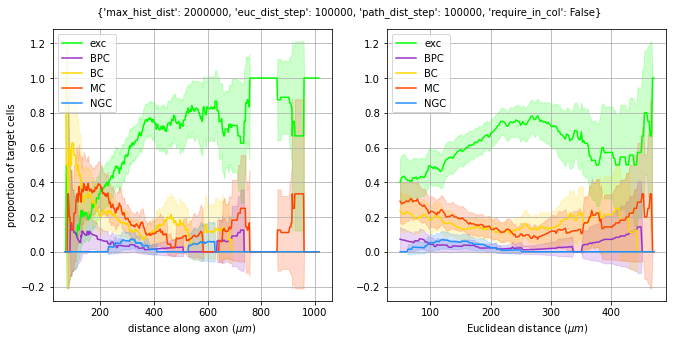

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for cell_type in syn_dfs:
    p = p_type_by_path_dists[cell_type]
    axes[0].plot(path_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    std_hat = np.sqrt(p * (1 - p) / (path_dist_step * path_total_density))
    axes[0].fill_between(path_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("proportion of target cells")
axes[0].legend()
axes[0].grid()
for cell_type in syn_dfs:
    p = p_type_by_euc_dists[cell_type]
    axes[1].plot(euc_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    sem = np.sqrt(p * (1 - p) / (euc_dist_step * euc_total_density))
    axes[1].fill_between(euc_bin_locs/1000, p - 2 * sem, p + 2 * sem, color=type_colors[cell_type], alpha=0.2)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
axes[1].grid()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [24]:
fig.savefig(os.path.join(results_dir, results_fname + "_p_type.png"))

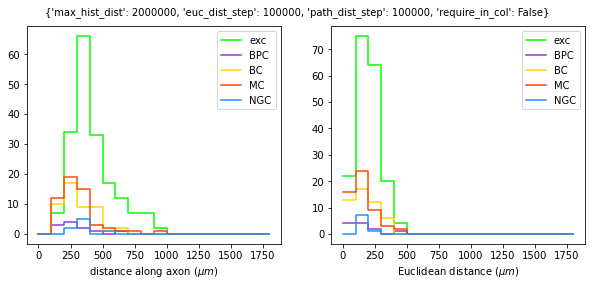

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in syn_dfs:
    axes[0].step(path_bin_edges[:-1]/1000, path_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].legend()
for cell_type in syn_dfs:
    axes[1].step(euc_bin_edges[:-1]/1000, euc_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [26]:
fig.savefig(os.path.join(results_dir, results_fname + "_hists.png"))

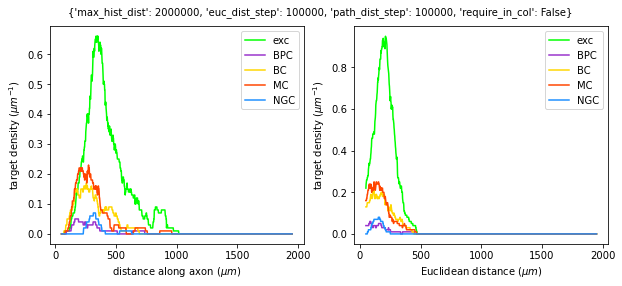

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in syn_dfs:
    axes[0].plot(path_bin_locs/1000, 1000*path_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("target density ($\mu m^{-1}$)")
axes[0].legend()
for cell_type in syn_dfs:
    axes[1].plot(euc_bin_locs/1000, 1000*euc_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].set_ylabel("target density ($\mu m^{-1}$)")
axes[1].legend()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [28]:
fig.savefig(os.path.join(results_dir, results_fname + "_densities.png"))

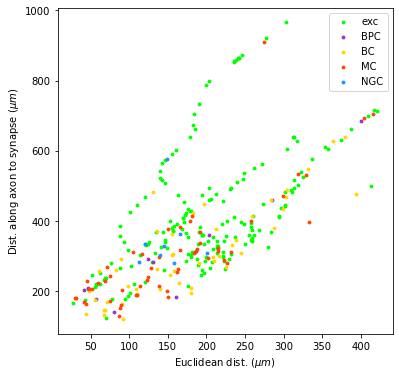

In [29]:
# plot euclidean distance to synapse vs path distance to synapse
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].euc_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("Euclidean dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [30]:
fig.savefig(os.path.join(results_dir, results_fname + "_euc_v_path.png"))

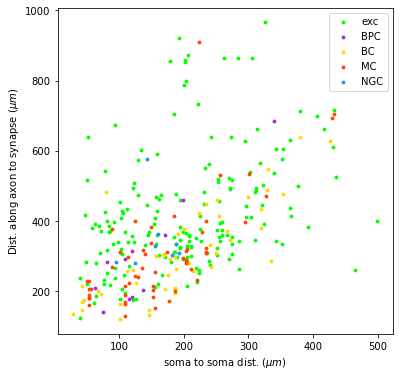

In [31]:
# plot path-distance along axon to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [32]:
fig.savefig(os.path.join(results_dir, results_fname + "_soma-soma_v_path.png"))

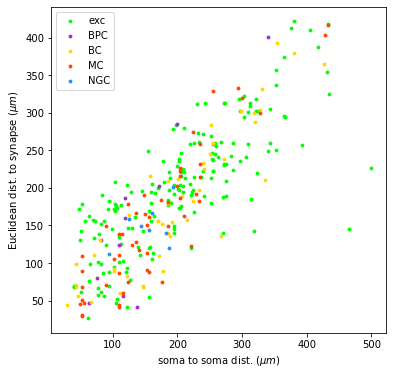

In [33]:
# plot euclidean distance to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].euc_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Euclidean dist. to synapse ($\mu m$)")
plt.legend()
plt.show()

In [34]:
fig.savefig(os.path.join(results_dir, results_fname + "_soma-soma_v_euc.png"))

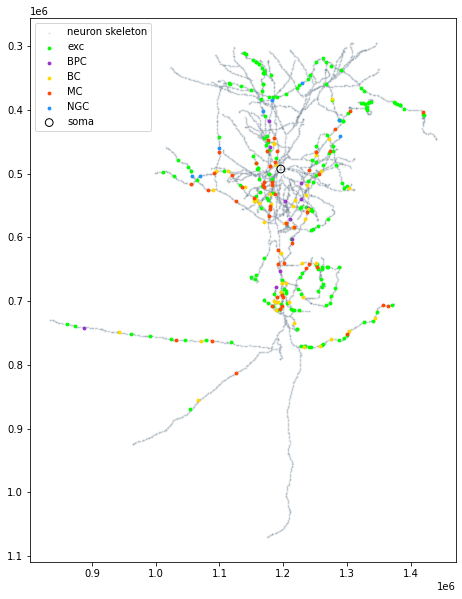

In [35]:
# plot the skeleton
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect(1)
ax.scatter(skel_vertices[:, 0], skel_vertices[:, 1], s=1, alpha=.2, c="lightslategrey", label="neuron skeleton")
for cell_type in syn_dfs:
    syn_locs = syn_dfs[cell_type].pre_pt_position.apply(vx_to_nm).values
    if len(syn_locs) > 0:
        syn_locs = np.stack(syn_locs)
        ax.scatter(syn_locs[:, 0], syn_locs[:, 1], s=8, c=type_colors[cell_type], alpha=1, label=cell_type)
ax.scatter(soma_loc[0], soma_loc[1], s=60, marker="o", facecolors='none', edgecolors='k', label="soma")
ax.invert_yaxis()
plt.legend()
plt.show()

In [36]:
fig.savefig(os.path.join(results_dir, results_fname + "_skeleton.png"))